# To html
python -m nbconvert --to html research.ipynb

# Load price data


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

path = "C:/Users/itataurov/Desktop/ccxt_data/data_parsed/1d/technical/binance/joined/binance_perps_joined.parquet"

df = pd.read_parquet(path)
df.rename(columns={'datetime':'timestamp'}, inplace=True)
df = df.sort_values(by=['timestamp'])

# Universe growth

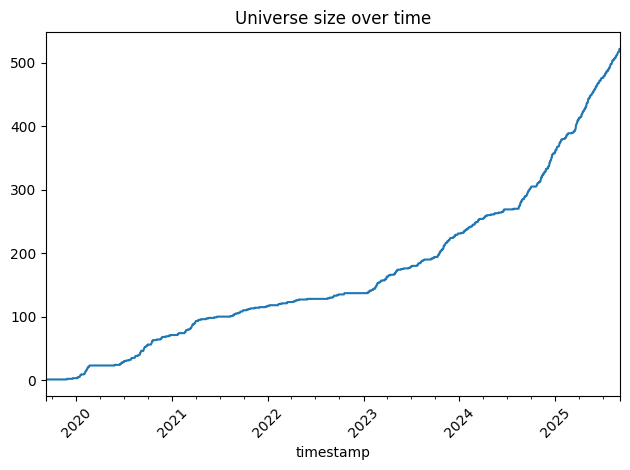

In [2]:
# plot universe size over time
df.groupby('timestamp').size().plot()
plt.title("Universe size over time")
plt.xticks(rotation=45)
plt.tight_layout()

In [32]:
# Add forward returns
def add_n_day_forward_returns(df, n):
	# print(f"Adding {n} period forward returns")
	df[f"fwd_return_{n}d"] = (
		df.groupby("symbol")["close"]
		.transform(lambda x: x.shift(-n) / x - 1)
	)
	
	# Define a helper that computes the future sum using reversed rolling window
	def future_sum(series, n):
		# Reverse the series so that future values become the "past"
		rev = series.iloc[::-1]
		# Compute a rolling sum on the reversed series; use min_periods=n to only include rows with a full window
		rolled = rev.rolling(window=n, min_periods=n).sum().iloc[::-1]
		# Shift by -1 to align each row with the sum of the NEXT n periods (i.e., skip the current row)
		return rolled.shift(-1)
	
	# Apply the helper to each group and make sure to reset the index to match df
	df[f'fwd_funding_return_{n}d'] = df.groupby('symbol')['fundingRate'] \
									   .apply(lambda s: future_sum(s, n)) \
									   .reset_index(level=0, drop=True)
	# combined
	df[f'fwd_combined_return_{n}d'] = df[f'fwd_return_{n}d'] - df[f'fwd_funding_return_{n}d']
	return df

for n in range(1, 61):
	df = add_n_day_forward_returns(df, n)

# copy df to de-fragment it
df = df.copy()

In [29]:
import numpy as np
import pandas as pd
import hashlib

def add_forward_returns_fast(df, max_n=60, symbol_col="symbol", time_col="datetime",
                             close_col="close", fund_col="fundingRate"):
    """
    Vectorized, fast version:
      - fwd_return_{n}d = close(t+n)/close(t) - 1  (per symbol)
      - fwd_funding_return_{n}d = sum of fundingRate over (t+1 ... t+n), requiring full n non-NaN obs
      - fwd_combined_return_{n}d = fwd_return_{n}d - fwd_funding_return_{n}d

    Handles NaNs in funding exactly like rolling(..., min_periods=n) by using counts.
    """
    # Sort for stable, per-symbol contiguous blocks
    sort_cols = [symbol_col] + ([time_col] if time_col in df.columns else [])
    df = df.sort_values(sort_cols).copy()

    sym = df[symbol_col].to_numpy()
    close = df[close_col].to_numpy(dtype=float)
    fr = df[fund_col].to_numpy(dtype=float)

    nrows = len(df)
    # Group boundaries
    _, starts = np.unique(sym, return_index=True)
    starts = np.sort(starts)
    ends = np.empty_like(starts)
    ends[:-1] = starts[1:]
    ends[-1] = nrows

    # Precompute per-group funding cumsums and counts (for min_periods=n behavior)
    cs_vals_list = []
    cs_cnts_list = []
    gclose_list = []
    glen_list = []

    for s, e in zip(starts, ends):
        gfr = fr[s:e]
        mask = ~np.isnan(gfr)
        vals = np.where(mask, gfr, 0.0)

        m = e - s
        glen_list.append(m)
        gclose_list.append(close[s:e])

        cs_vals = np.empty(m + 1, dtype=float)
        cs_vals[0] = 0.0
        np.cumsum(vals, out=cs_vals[1:])  # sum of non-NaN values

        cs_cnts = np.empty(m + 1, dtype=np.int64)
        cs_cnts[0] = 0
        np.cumsum(mask.astype(np.int64), out=cs_cnts[1:])  # count of non-NaN values

        cs_vals_list.append(cs_vals)
        cs_cnts_list.append(cs_cnts)

    # Main loop over n (fast, pure NumPy slicing inside)
    for n in range(1, max_n + 1):
        pr = np.full(nrows, np.nan, dtype=float)  # price fwd return
        ff = np.full(nrows, np.nan, dtype=float)  # funding fwd sum

        gi = 0
        for (s, e), m in zip(zip(starts, ends), glen_list):
            if n < m:
                gcl = gclose_list[gi]
                # price: t+n over t, NaN propagates naturally if either side NaN
                pr[s:e - n] = gcl[n:] / gcl[:-n] - 1.0

                # funding sum over future n (t+1...t+n), require full n non-NaN values
                cs_vals = cs_vals_list[gi]
                cs_cnts = cs_cnts_list[gi]
                # out[i] = cs_vals[i+n+1] - cs_vals[i+1], cnt = cs_cnts[i+n+1] - cs_cnts[i+1]
                sum_arr = cs_vals[(n + 1):(m + 1)] - cs_vals[1:(m + 1 - n)]
                cnt_arr = cs_cnts[(n + 1):(m + 1)] - cs_cnts[1:(m + 1 - n)]

                tmp = np.full(m - n, np.nan, dtype=float)
                ok = (cnt_arr == n)
                tmp[ok] = sum_arr[ok]
                ff[s:e - n] = tmp

            gi += 1

        df[f"fwd_return_{n}d"] = pr
        df[f"fwd_funding_return_{n}d"] = ff
        df[f"fwd_combined_return_{n}d"] = pr - ff

    return df

In [34]:
def fingerprint_forward_returns(df, max_n=60, hash_key="fwdret_v1"):
    """
    Stable SHA-256 fingerprint of all forward-return columns.
    Uses pandas.util.hash_pandas_object with a fixed hash_key so it's reproducible across runs.
    """
    cols = []
    for n in range(1, max_n + 1):
        cols += [f"fwd_return_{n}d", f"fwd_funding_return_{n}d", f"fwd_combined_return_{n}d"]
    cols = [c for c in cols if c in df.columns]

    if not cols:
        return None

    hvec = pd.util.hash_pandas_object(df[cols], index=True, hash_key=hash_key)
    digest = hashlib.sha256(hvec.values.tobytes()).hexdigest()
    return digest

In [ ]:
print("fingerprint:", fingerprint_forward_returns(df, max_n=60))

# slow finger print: 8d072c5a31c442ee41aea5e125170c968c8077a386ea9ebf2d1634318045b18f

fingerprint: 8d072c5a31c442ee41aea5e125170c968c8077a386ea9ebf2d1634318045b18f


In [ ]:
# Build all forward-return columns up to 60 days
df = add_forward_returns_fast(df, max_n=60)

# Optional: de-fragment after huge column adds
df = df.copy()

# Get a correctness fingerprint (run again later to compare)
print("fingerprint:", fingerprint_forward_returns(df, max_n=60))


In [4]:
# make vol a mix of long term(using expanding window) and short term (using ewm)
df['return'] = df.groupby('symbol')['close'].pct_change()
df['vol_expanding_window'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.expanding(min_periods=30)
					.std())
)
df['vol_ewm'] = (
	df.groupby('symbol')['return']
		.transform(lambda x: x
					.ewm(span=30, adjust=False, min_periods=30)
					.std())
)
df['volatility'] = (
	df['vol_expanding_window'] * 0.25 +
	df['vol_ewm'] * 0.75
)

In [5]:
# Universe selection
df['dollar_volume'] = df['close'] * df['volume']
df['dollar_volume_slowed'] = (
	df.groupby('symbol')['dollar_volume']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['dv_rank'] = (
	df.groupby('timestamp')['dollar_volume_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['dv_decile'] = df.groupby('timestamp')['dollar_volume_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

df['market_cap_slowed'] = (
	df.groupby('symbol')['mkt_cap']
		.transform(lambda x: x.ewm(span=60, min_periods=30, adjust=False).mean())
)
df['mc_rank'] = (
	df.groupby('timestamp')['market_cap_slowed']
		.rank(method='first', ascending=False)
		.fillna(1000000)
		.astype(int)
)
df['mc_decile'] = df.groupby('timestamp')['market_cap_slowed'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop')) + 1

# days since listing
df['days_since_listing'] = df.groupby('symbol').cumcount() + 1

# Compute signal

In [6]:
import signals

lookbacks = [1,2, 4, 8, 16, 32, 64, 128]

for l in lookbacks:
	print(f"Computing signal for lookback {l}")
	df = signals._compute_bolmom(df, f'signal_{l}d', l)


Computing signal for lookback 1
Computing Bollinger Band momentum signal...
Computing signal for lookback 2
Computing Bollinger Band momentum signal...
Computing signal for lookback 4
Computing Bollinger Band momentum signal...
Computing signal for lookback 8
Computing Bollinger Band momentum signal...
Computing signal for lookback 16
Computing Bollinger Band momentum signal...
Computing signal for lookback 32
Computing Bollinger Band momentum signal...
Computing signal for lookback 64
Computing Bollinger Band momentum signal...
Computing signal for lookback 128
Computing Bollinger Band momentum signal...


# Filter illiquids 

In [7]:
# Select universe
df_filtered = df[df.dollar_volume_slowed >= 1e6] # at least $1M daily volume 
df_filtered = df[df['days_since_listing'] >= 90] # at least 90 days since listing (need data for risk estimate)
df_filtered = df_filtered[df_filtered.timestamp<'2025-01-01']
df_filtered = df_filtered[df_filtered.timestamp>'2021-01-01']
print(f"Filtered down from {len(df)} to {len(df_filtered)} rows")

Filtered down from 371753 to 226544 rows


In [8]:
# 1) define your three 60-column groups
price_cols    = [f"fwd_return_{n}d"          for n in range(1, 61)]
funding_cols  = [f"fwd_funding_return_{n}d"  for n in range(1, 61)]
combined_cols = [f"fwd_combined_return_{n}d" for n in range(1, 61)]

# 2) vectorized demean in-place, naming *_demeaned_fast
for cols in (price_cols, funding_cols, combined_cols):
	# compute per-timestamp means for all cols at once
	means = df_filtered.groupby("timestamp")[cols].transform("mean")
	# subtract and assign to new *_demeaned_fast columns
	fast_cols = [f"{c}_demeaned" for c in cols]
	df_filtered[fast_cols] = df_filtered[cols] - means

df_filtered = df_filtered.copy() # de-fragment

C:\Users\itataurov\AppData\Local\Temp\ipykernel_18948\2048877694.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered[fast_cols] = df_filtered[cols] - means
C:\Users\itataurov\AppData\Local\Temp\ipykernel_18948\2048877694.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_filtered[fast_cols] = df_filtered[cols] - means
C:\Users\itataurov\AppData\Local\Temp\ipykernel_18948\2048877694.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which 

In [9]:
df_filtered.columns[0:30]

Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'mkt_cap', 'fundingRate', 'oi', 'ls_ratio', 'longs_pct',
       'buy_volume_perp', 'total_volume_perp', 'buy_trades_perp',
       'total_trades_perp', 'spot_close', 'buy_volume_spot',
       'total_volume_spot', 'buy_trades_spot', 'total_trades_spot',
       'predicted_funding_rate', 'short_liquidation_volume',
       'long_liquidation_volume', 'fwd_return_1d', 'fwd_funding_return_1d',
       'fwd_combined_return_1d', 'fwd_return_2d', 'fwd_funding_return_2d',
       'fwd_combined_return_2d'],
      dtype='object')

# Visualize signals

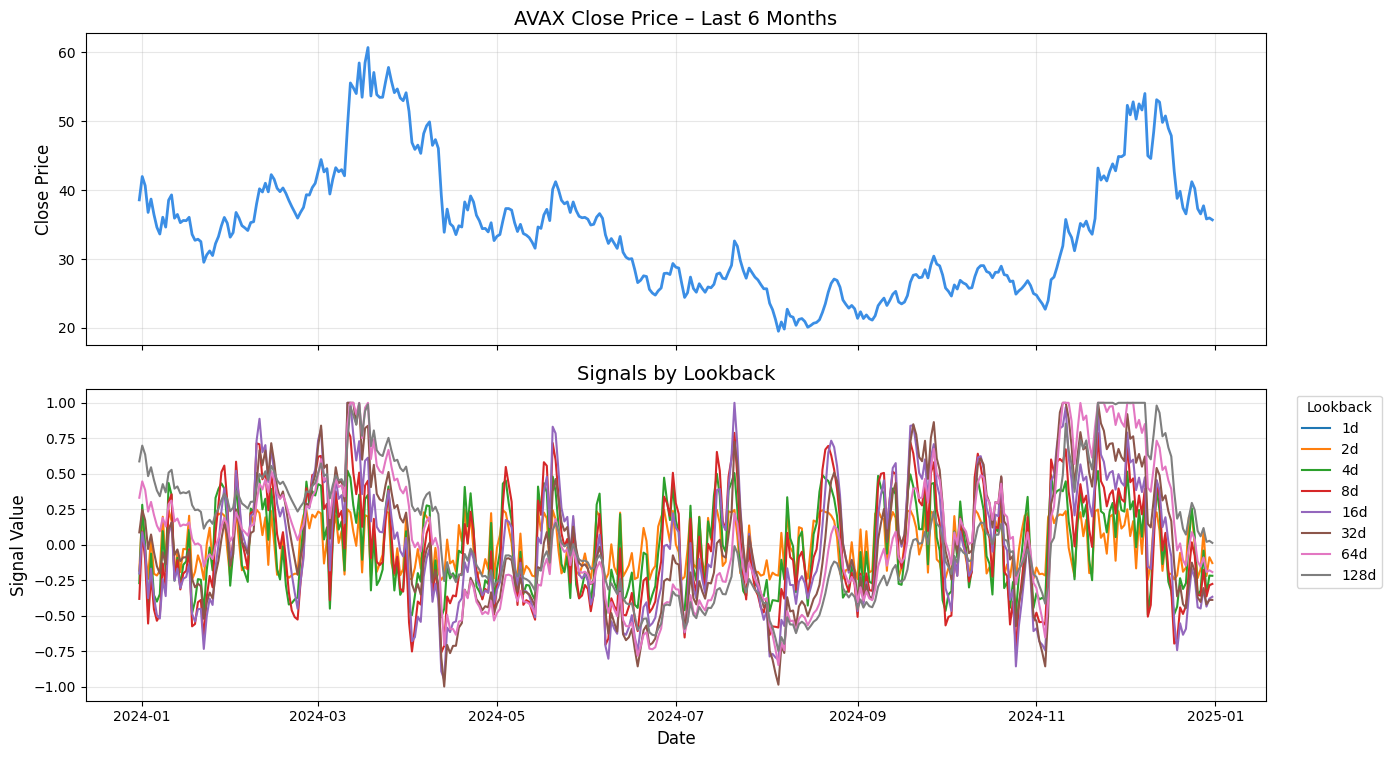

In [10]:
import matplotlib.pyplot as plt
import pandas as pd

# --- AVAX slice, last 12 months ----------------------------
btc = df_filtered[df_filtered['symbol'] == 'AVAX'].copy()
btc['timestamp'] = pd.to_datetime(btc['timestamp'])
end   = btc['timestamp'].max()
start = end - pd.DateOffset(months=12)
btc   = btc[btc['timestamp'] >= start]

# --- plot: price on top, signals bottom (equal height) ------------------
fig, (ax1, ax2) = plt.subplots(
	nrows=2,
	ncols=1,
	sharex=True,
	figsize=(14, 8),
	gridspec_kw={"height_ratios": [1, 1]}  # equal heights
)

# Top: AVAX price
ax1.plot(btc['timestamp'], btc['close'], color="#3B8EE5", lw=2)
ax1.set_ylabel('Close Price', fontsize=12)
ax1.set_title('AVAX Close Price – Last 6 Months', fontsize=14)
ax1.grid(True, alpha=0.3)

# Bottom: signals
for l in lookbacks:
	ax2.plot(
		btc['timestamp'],
		btc[f'signal_{l}d'],
		lw=1.5,
		label=f'{l}d'
	)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Signal Value', fontsize=12)
ax2.set_title('Signals by Lookback', fontsize=14)
ax2.legend(
	title='Lookback',
	bbox_to_anchor=(1.02, 1),
	loc='upper left'
)
ax2.grid(True, alpha=0.3)

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Lookback selection

### IC vs lookback

1


C:\Users\itataurov\AppData\Local\Temp\ipykernel_18948\2409898226.py:27: RuntimeWarning: divide by zero encountered in scalar divide
  avg_hold       = 1.0 / avg_turn


2
4
8
16
32
64
128


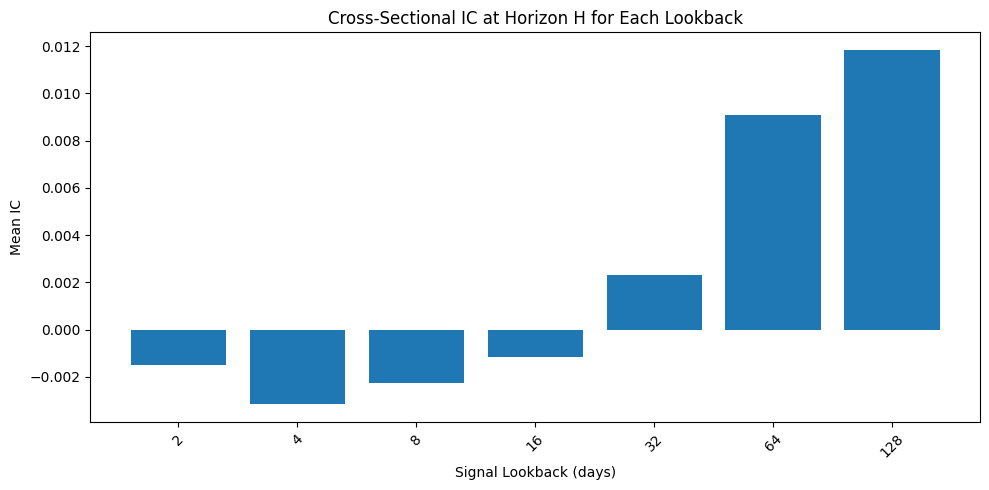

          avg_turnover  avg_hold_days  horizon_H        IC
lookback                                                  
1             0.000000            inf         10       NaN
2             1.207966       0.827838         10 -0.001505
4             0.988430       1.011706         10 -0.003171
8             0.776565       1.287723         10 -0.002260
16            0.584393       1.711177         10 -0.001147
32            0.426841       2.342794         10  0.002328
64            0.306043       3.267520         10  0.009082
128           0.220415       4.536905         10  0.011836


In [11]:
results = []

for l in lookbacks:
	print(l)
	sig_col = f"signal_{l}d"

	# ——— 1) build the raw signal matrix, with NaNs for missing symbols ———
	S = df_filtered.pivot(
		index="timestamp",
		columns="symbol",
		values=sig_col,
	)  # missing value -> NaN

	# ——— 2) subtract the cross‐sectional mean (skipna=True by default) ———
	S0 = S.sub(S.mean(axis=1), axis=0)

	# ——— 3) normalize by the sum of abs deviations (skipna=True) ———
	norm = S0.abs().sum(axis=1)
	W = S0.div(norm, axis=0)

	# ——— 4) put missing positions back to 0 (just like your unstack(fill_value=0)) ———
	W = W.fillna(0)

	# ——— 5) turnover exactly as before ———
	daily_turnover = W.diff().abs().sum(axis=1).iloc[1:]
	avg_turn       = daily_turnover.mean()
	avg_hold       = 1.0 / avg_turn
	H              = 10 #int(round(avg_hold))

	# ——— 6) horizon‐matched IC exactly as before ———
	ret_col   = f"fwd_combined_return_{H}d_demeaned"
	daily_ics = (
		df_filtered
		.groupby("timestamp")[[sig_col, ret_col]]
		.apply(lambda g: g.iloc[:, 0].corr(g.iloc[:, 1], min_periods=2))
		.dropna()
	)
	ic_H = daily_ics.mean()

	results.append({
		"lookback":      l,
		"avg_turnover":  avg_turn,
		"avg_hold_days": avg_hold,
		"horizon_H":     H,
		"IC":            ic_H,
	})

metrics = pd.DataFrame(results).set_index("lookback")

plt.figure(figsize=(10, 5))
plt.bar(metrics.index.astype(str), metrics["IC"])
plt.title("Cross-Sectional IC at Horizon H for Each Lookback")
plt.xlabel("Signal Lookback (days)")
plt.ylabel("Mean IC")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(metrics)


# Signal Selection

In [18]:
df_filtered['signal'] = df_filtered['signal_128d']

Holding-period estimator ``H = 1/avg_turnover`` assumes ``GMV = 1``.

In [19]:
# find turnover for future plots
df_filtered['weight'] = df_filtered.groupby('timestamp')['signal'].transform(
		lambda x: (x - x.mean()) / (x - x.mean()).abs().sum()
)
W = df_filtered.pivot(values='weight', columns='symbol', index='timestamp')
avg_holding_period = 1/W.diff().abs().sum(axis=1).mean()
print(f"Avg holding period: {avg_holding_period:.2f}")

Avg holding period: 4.57


# Signal distribution

Five-number summary:
  Min     : -1.0000
  25th %ile: -0.3634
  Median  : -0.1551
  75th %ile: 0.2297
  Max     : 1.0000


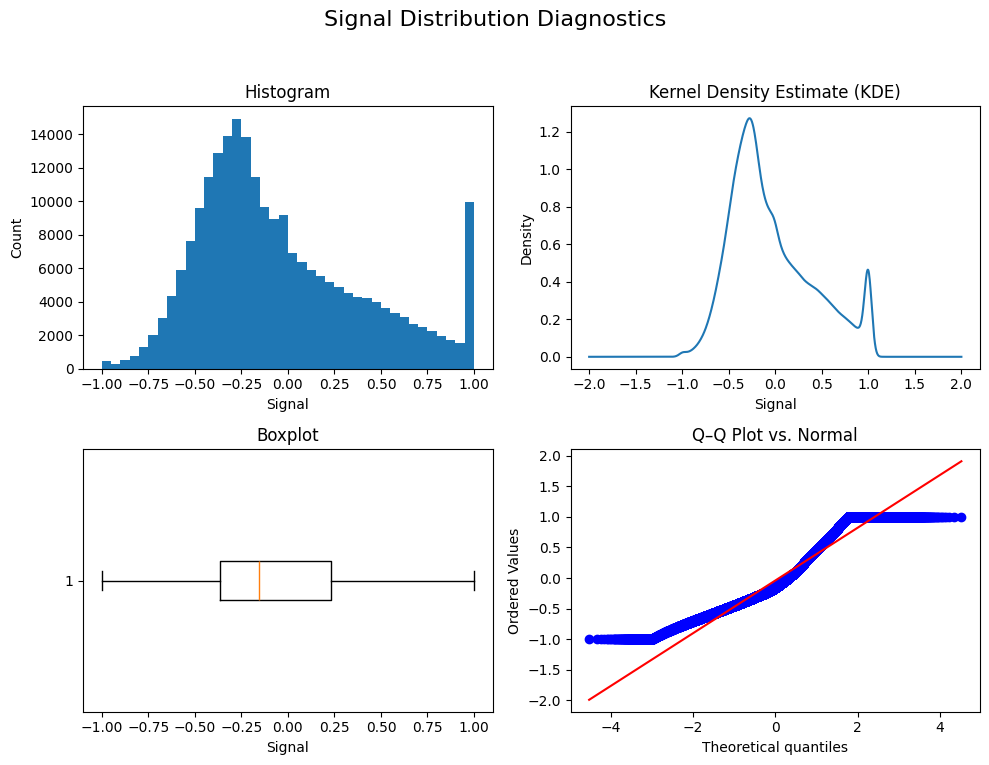

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st

# extract and clean
signal = df_filtered['signal'].dropna()

# compute five-number summary
five_num = signal.quantile([0, .25, .5, .75, 1.0])
print("Five-number summary:")
print(f"  Min     : {five_num.loc[0.00]:.4f}")
print(f"  25th %ile: {five_num.loc[0.25]:.4f}")
print(f"  Median  : {five_num.loc[0.50]:.4f}")
print(f"  75th %ile: {five_num.loc[0.75]:.4f}")
print(f"  Max     : {five_num.loc[1.00]:.4f}")

# set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle('Signal Distribution Diagnostics', fontsize=16)

# 1. Histogram
axes[0, 0].hist(signal, bins=40)
axes[0, 0].set_title('Histogram')
axes[0, 0].set_xlabel('Signal')
axes[0, 0].set_ylabel('Count')

# 2. KDE
signal.plot.kde(ax=axes[0, 1])
axes[0, 1].set_title('Kernel Density Estimate (KDE)')
axes[0, 1].set_xlabel('Signal')

# 3. Boxplot
axes[1, 0].boxplot(signal, vert=False)
axes[1, 0].set_title('Boxplot')
axes[1, 0].set_xlabel('Signal')

# 4. Q–Q Plot
st.probplot(signal, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q–Q Plot vs. Normal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# Performance by ADV decile

dv_decile
1.0     0.021138
2.0    -0.000937
3.0     0.026490
4.0     0.016027
5.0     0.024378
6.0    -0.014816
7.0     0.001089
8.0    -0.016701
9.0     0.054992
10.0    0.018468
dtype: float64


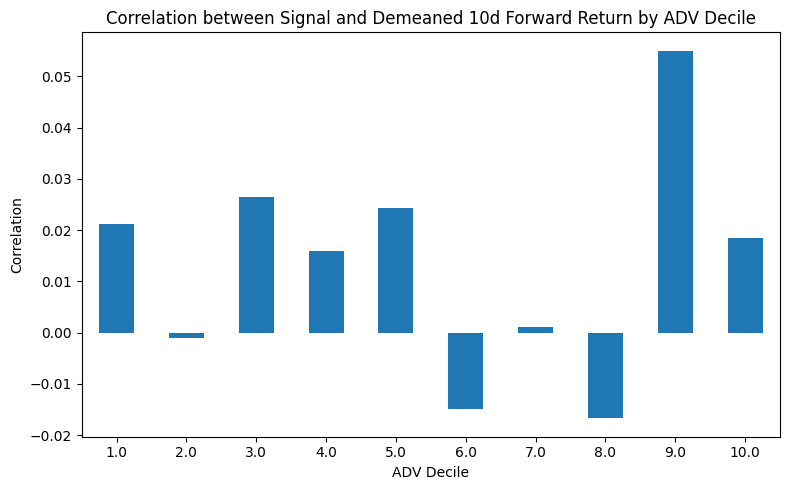

In [21]:
# Assuming df_filtered is already defined from earlier cells
# Compute correlation by dv_decile: demean fwd_combined_return_5d within each group, then corr with signal
correlations = df_filtered.groupby('dv_decile')[['signal', 'fwd_combined_return_5d_demeaned']].apply(
	lambda g: g['signal'].corr(g['fwd_combined_return_5d_demeaned'])
)

# Print the results (Series with dv_decile as index)
print(correlations)

# Optional: Plot for visualization
import matplotlib.pyplot as plt
correlations.plot(kind='bar', figsize=(8, 5))
plt.title('Correlation between Signal and Demeaned 10d Forward Return by ADV Decile')
plt.xlabel('ADV Decile')
plt.ylabel('Correlation')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Regression fit

In [22]:
import statsmodels.api as sm
import numpy as np

# Choose which model to fit
use_interaction = True   # set False if you only want signal
target = 'fwd_combined_return_10d_demeaned'


if use_interaction:
    dataset = df_filtered[['signal', 'dv_decile', target]].dropna()

    # Create interaction term
    dataset['signal_x_dv_decile'] = dataset['signal'] * dataset['dv_decile']

    X = dataset[['signal', 'dv_decile', 'signal_x_dv_decile']]
    y = dataset[target]

    # Add constant
    X = sm.add_constant(X)

    # Fit model
    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept        = model.params['const']
    coef_signal      = model.params['signal']
    coef_dv_decile   = model.params['dv_decile']
    coef_interaction = model.params['signal_x_dv_decile']

    # Forecast
    df_filtered['forecast'] = (
        intercept
        + coef_signal * df_filtered['signal']
        + coef_dv_decile * df_filtered['dv_decile']
        + coef_interaction * df_filtered['signal'] * df_filtered['dv_decile']
    )

else:
    dataset = df_filtered[['signal', target]].dropna()

    X = sm.add_constant(dataset[['signal']])
    y = dataset[target]

    model = sm.OLS(y, X).fit()

    # Extract coefficients
    intercept   = model.params['const']
    coef_signal = model.params['signal']

    # Forecast
    df_filtered['forecast'] = intercept + coef_signal * df_filtered['signal']

dataset = df_filtered[['dv_decile', target]].dropna()

print(model.summary())


                                   OLS Regression Results                                   
Dep. Variable:     fwd_combined_return_10d_demeaned   R-squared:                       0.001
Model:                                          OLS   Adj. R-squared:                  0.001
Method:                               Least Squares   F-statistic:                     52.13
Date:                              Fri, 12 Sep 2025   Prob (F-statistic):           1.13e-33
Time:                                      16:07:59   Log-Likelihood:                 92213.
No. Observations:                            216861   AIC:                        -1.844e+05
Df Residuals:                                216857   BIC:                        -1.844e+05
Df Model:                                         3                                         
Covariance Type:                          nonrobust                                         
                         coef    std err          t      P>|t|      [0

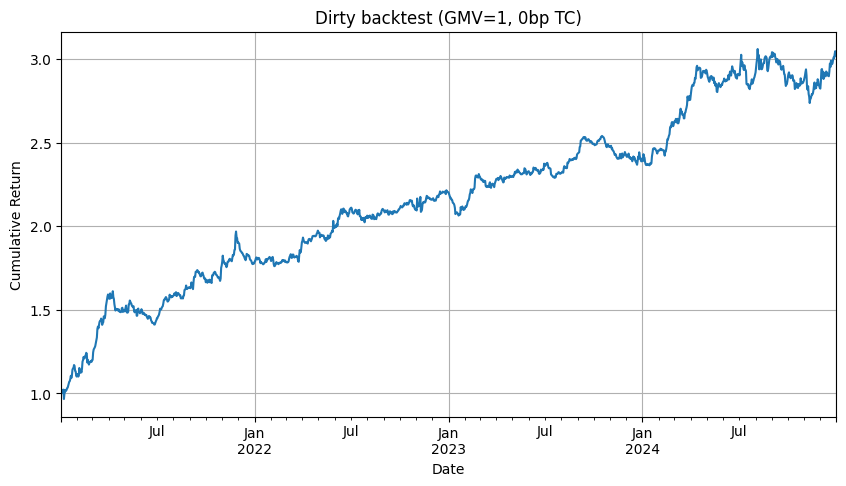

In [23]:
signals_wide = df_filtered.pivot(index='timestamp', columns='symbol', values='forecast')
df_filtered['return'] = df_filtered.groupby('symbol')['close'].pct_change()
returns_wide = df_filtered.pivot(index='timestamp', columns='symbol', values='return')

# generate stat-arb weights (demean + l1 norm)
W = signals_wide.sub(signals_wide.mean(axis=1), axis=0)
W = W.div(W.abs().sum(axis=1), axis=0)
W = W.fillna(0)

# compute daily PnL
pnl = (W.shift(1) * returns_wide).sum(axis=1)

# TC
turnover = (W.fillna(0) - W.shift(1).fillna(0)).abs().sum(axis=1)  # one-way traded notional
cost_bps = 0  # e.g., 1bp per one-way
pnl = pnl - (cost_bps/1e4) * turnover

# plot cumulative PnL
(pnl + 1).cumprod().plot(figsize=(10, 5))
plt.title(f"Dirty backtest (GMV=1, {cost_bps}bp TC)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()